# Import librairies

In [1]:
print ('Importing librairies...')
# To solve equation
from dolfin import* 

# For figures
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style
from Diffusion_model.Plot_functions import*

# For physical parameters
from CoolProp.CoolProp import PropsSI

# Various functions
import Diffusion_model.Auxiliary_functions
from Diffusion_model.Auxiliary_class import*
import numpy as np
import time
import geopandas as gpd
import pyproj
import pickle as pkl
from pyproj import Transformer
print ('Librairies imported')

Importing librairies...
Librairies imported


# Extract QUEST reservoir data

In [2]:
# Extract Quest data
df_PCS = pd.read_excel('Quest, LCS, PCS.xlsx', sheet_name='Pre-Cambrian')

# Convert GPS coordinates in UTM format
wgs84 = pyproj.CRS("EPSG:4326")
utm = pyproj.CRS("EPSG:26712")
transformer = Transformer.from_crs(wgs84, utm)
def convert_to_cartesian(longitude, latitude):
    x, y = transformer.transform(latitude, longitude)
    return x, y
df_PCS['X'], df_PCS['Y'] = zip(*df_PCS.apply(lambda row: convert_to_cartesian(-row['Long'], row['Lat']), axis=1))

# Area Of Interest coordinates
df_AOI = pd.read_csv('AOI.csv', sep=';', names=['Long', 'Lat'])
df_AOI['X'], df_AOI['Y'] = zip(*df_AOI.apply(lambda row: convert_to_cartesian(-row['Long'], row['Lat']), axis=1))
AOI = [[df_AOI['X'][ind], df_AOI['Y'][ind]] for ind in df_AOI.index]

x_min = np.min(df_AOI['X']) ; x_max = np.max(df_AOI['X'])
y_min = np.min(df_AOI['Y']) ; y_max = np.max(df_AOI['Y'])
xmin = x_min - 0.1*(x_max-x_min) ; xmax = x_max + 0.1*(x_max-x_min)
ymin = y_min - 0.1*(y_max-y_min) ; ymax = y_max + 0.1*(y_max-y_min)
Outline = [Point(xmin,ymin), Point(xmax,ymin), Point(xmax,ymax), Point(xmin,ymax), Point(xmin,ymin)]

# Model parameters

In [3]:
# General parameters
Temp = 10 # C # Temperature of the reservoir
Temp += 273.15 # K
p_ref = 2.0*1e7 # Pa # pressure reference (must be close to the pressure engaged in the reservoir)
p_extrem = 2.5*1e7
g = 9.81 # m.s-2
H0 = 47 # m # Thickness of the reservoir

# Depth of the reservoir. We initialize the depth using values of depth at some points.
# The field is then interpolated.
depth_points = []
depth_field = []
for ind in df_PCS.index:
    if xmin<df_PCS['X'][ind]<xmax and ymin<df_PCS['Y'][ind]<ymax:
        depth_points.append([df_PCS['X'][ind], df_PCS['Y'][ind]])
#         depth_field.append(df_PCS['Depth_PCS'][ind]+H0)
        depth_field.append(50*df_PCS['Depth_PCS'][ind]+H0)
#         depth_field.append(-1400) # For flat reservoir
depth_points = np.array(depth_points)
depth_field = np.array(depth_field)

# Thickness of the reservoir. Same procedure than depth.
H_points = np.array(depth_points)
H_field = np.array([H0 for ind in range(len(H_points))])

# Reservoir physical parameters : permeability and porosity. Same procedure than thickness.
k0 = 1e-13 # m2
k_points = np.array([[xmin, xmax], [xmax, ymax], [xmin, ymin], [xmax, ymin]])
k_field = np.array([k0, k0, k0, k0])

phi0 = 0.30
phi_points = np.array([[xmin, xmax], [xmax, ymax], [xmin, ymin], [xmax, ymin]])
phi_field = np.array([phi0, phi0, phi0, phi0])

# Rock compressiblity. Has a small impact on results.
cr = 3e-11 # Pa-1

# Gas. Parameters calculated with CoolProp.
rho_g0 = PropsSI('D', 'T', Temp, 'P', p_ref, 'CO2') # kg.m-3 # density of gas
cg = PropsSI('ISOTHERMAL_COMPRESSIBILITY', 'T', Temp, 'P', p_ref, 'CO2') # Pa-1 # gas compressibility
mug0 = PropsSI('V', 'T', Temp, 'P', p_ref, 'CO2') # Pa.s # viscosity of gas
mug1 = PropsSI('V', 'T', Temp, 'P', p_extrem, 'CO2')
cvg = (mug1-mug0)/(p_extrem-p_ref)
krg = 1 # m2 # Relative permeability of gas in gas region
sg = 0.8 # saturation of gas in the gas region
def rho_g(p): return(rho_g0*(1+cg*(p-p_ref))) # Density profile
def mug(p): return(mug0*(1+cvg*(p-p_ref))) # Viscosity profile

# Water. Parameters calculated with CoolProp.
rho_w0 = PropsSI('D', 'T', Temp, 'P', p_ref, 'WATER') # kg.m-3 # density of water
cw = PropsSI('ISOTHERMAL_COMPRESSIBILITY', 'T', Temp, 'P', p_ref, 'WATER') # Pa-1 # water compressibility
muw0 = PropsSI('V', 'T', Temp, 'P', p_ref, 'WATER') # Pa.s # viscosity of water
muw1 = PropsSI('V', 'T', Temp, 'P', p_extrem, 'WATER')
cvw = (muw1-muw0)/(p_extrem-p_ref)
krw = 1 # m2 # Relative permeability of water
def rho_w(p): return(rho_w0*(1+cw*(p-p_ref))) # Density profile
def muw(p): return(muw0*(1+cvw*(p-p_ref))) # Viscosity profile

# Steps parameter
minute = 60 # s
hour = 60*minute
day = 24*hour
year = 365*day

dt = 1*minute
dt_max = 60*day
T_tot = 60*year # Simulation stopped at T_tot (even if the injection scenario is longer)

###########################################################################################################################
# Plot profiles for densities and viscosities
T_min = 20 # °C
T_max = 80 # °C
p_min = 1e7 # Pa
p_max = 3e7 # Pa

# Sources

In [4]:
Sources_g = []
# [location, [rates] in kg.s-1, [Times of operation]]
# Total amount of gas stored per year = 1.08 Mt
Rate_per_well = 1.08e9/365/24/3600/3 # convert to kg.s-1 and divide by 3
Sources_g.append([Point(370705.4800,5997747.3900), [Rate_per_well], [[T_tot/2, T_tot]]])
Sources_g.append([Point(367400,6001000), [Rate_per_well], [[T_tot/2, T_tot]]])
Sources_g.append([Point(376800,5994400), [Rate_per_well], [[T_tot/2, T_tot]]])

sigma = 100 # m # source term standard deviation

# Meshgrid and model settings

Number of cells = 6176
66.36329091639493
3333.735283499833


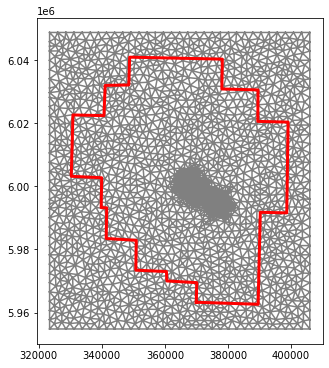

In [5]:
# Form compiler options
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True
PETScOptions.set("pc_hypre_boomeramg_strong_threshold", .25)
PETScOptions.set("pc_hypre_boomeramg_truncfactor", 0.0)

# Create mesh and build function space
domain = Polygon(Outline)
Nm = 30 # define the global mesh fineness
Nhr = 2 # define the fineness of the mesh around the hydraulic radius of each well
Nst = 3 # define the fineness of the mesh around each source
        # Source term will always be at least as accurate as hydraulic radius. We add Nst degrees of accuracy.

mesh = Diffusion_model.Auxiliary_functions.create_mesh(domain, Nm, Nhr, Nst, Sources_g, sigma, T_tot, phi0, sg, rho_g0, H0)
print('Number of cells = '+str(mesh.num_cells()))
print(mesh.hmin())
print(mesh.hmax())

P1 = FiniteElement('Lagrange', triangle, 1)
ME = FunctionSpace(mesh, P1*P1)
ME1 = FunctionSpace(mesh, P1)
ME2=VectorFunctionSpace(mesh, "DG", 0)

###########################################################################################################################
# Plot mesh and each well

fig = plt.figure(figsize=(6,6))
# plot_wells(Sources_g) # plot wells (red dots).

plot(mesh)
ax = plt.gca()
plot_AOI(ax, AOI, 'red')
# plt.savefig('Diffusion_model/Figures/QUEST_mesh_reservoir.png', dpi=300)
# fig.set_size_inches([6, 12])

In [6]:
# Define trial and test functions
du    = TrialFunction(ME)
v  = TestFunction(ME)

# Define functions
u   = Function(ME)  # current solution
u0  = Function(ME)  # solution from previous converged step

# Split mixed functions
dp, dh = split(du)
p,  h  = split(u)
p0, h0 = split(u0)
v_h, v_p = split(v)

# Initial conditions

Interpolating initial conditions...
... interpolated
Injected mass at t = 10.0 days : 0.0 kg.s-1


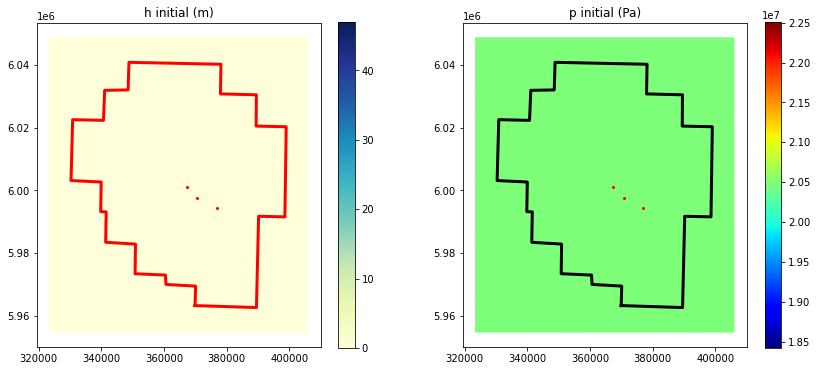

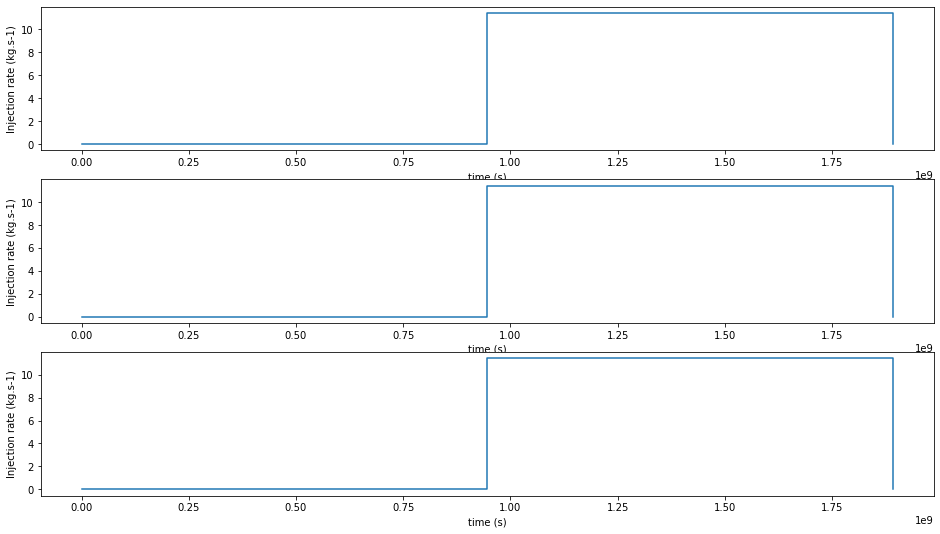

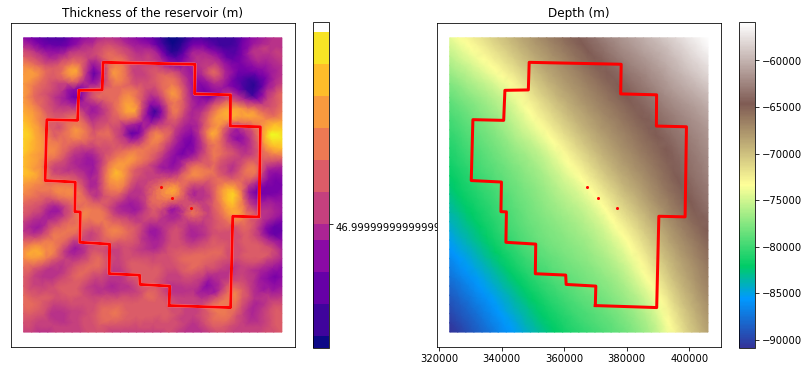

In [7]:
Coords = ME1.tabulate_dof_coordinates() # Coordinates of the mesh

# All the data are interpolated using : Radial basis function interpolation (RBF).
# Initial pressure
p_0 = 204.65e5 # Pa
p_points = np.array([[xmin, xmax], [xmax, ymax],
                     [xmin, ymin], [xmax, ymin]])
p_field = np.array([p_0, p_0,
                    p_0, p_0])
p_init = griddata(p_points, p_field, Coords, method='linear') # Linear interpolation

# Initial thickness of gas
h_0 = 0 # m
h_points = np.array([[xmin, xmax], [xmax, ymax],
                     [xmin, ymin], [xmax, ymin]])
h_field = np.array([h_0, h_0,
                    h_0, h_0])
h_init = griddata(h_points, h_field, Coords, method='linear')  # Linear interpolation

# Now that we have the mesh, we can interpolate H, phi and k.
H = H_function(mesh, H_points, H_field.flatten(), ME1)
k = k_function(mesh, k_points, k_field.flatten(), ME1)
phi = phi_function(mesh, phi_points, phi_field.flatten(), ME1)
depth = depth_function(mesh, depth_points, depth_field.flatten(), ME1)

print('Interpolating initial conditions...')
u_init = InitialConditions(p_points, p_field, h_points, h_field, ME1)
u.interpolate(u_init)
u0.interpolate(u_init)
print('... interpolated')

###########################################################################################################################
# Plot initial conditions

# Display real injected mass. This function can be used to verify the amount of the fluid which is injected at a given time.
t_inj = 10*day # Time when we want to verify the injected mass (mass flow rate).
s_g_ = Function(ME1) ; s_g_.interpolate(s(Sources_g, t_inj, ME1, sigma))
print('Injected mass at t = ' + day_format(t_inj) + ' : ' + str(assemble(s_g_*dx)) + ' kg.s-1')

# Plot initial conditions
plt.subplots(figsize=(14,6))
plt.subplot(1,2,1) ; plot_wells(Sources_g)
plt.colorbar(plot(u.split()[1], title='h initial (m)', mode='color', cmap='YlGnBu', vmin=h_0, vmax= H0), orientation='vertical')
ax = plt.gca() ; plot_AOI(ax, AOI, 'red')
plt.subplot(1,2,2) ; plot_wells(Sources_g)
plt.colorbar(plot(u.split()[0], title='p initial (Pa)', mode='color', cmap='jet'), orientation='vertical')
ax = plt.gca() ; plot_AOI(ax, AOI, 'black')
plt.savefig('Diffusion_model/Figures/QUEST_initial_conditions.png', dpi=300, bbox_inches='tight')

# Plot sources
Ns = len(Sources_g)
plt.subplots(figsize=(16,3*Ns))
for i in range(Ns): plt.subplot(Ns,1,1+i) ; plot_source(Sources_g[i], T_tot)

# Plot porosity, permeability, H and depth
plt.subplots(figsize=(14,6))
plt.subplot(1,2,1) ; plot_wells(Sources_g)
plt.colorbar(plot(H, title='Thickness of the reservoir (m)', mode='color', cmap='plasma'), orientation='vertical')
ax = plt.gca() ; plot_AOI(ax, AOI, 'white')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = plt.gca() ; plot_AOI(ax, AOI, 'red')
plt.subplot(1,2,2) ; plot_wells(Sources_g)
plt.colorbar(plot(depth, title='Depth (m)', mode='color', cmap='terrain'), orientation='vertical')
ax = plt.gca() ; plot_AOI(ax, AOI, 'red')
ax.yaxis.set_visible(False)
plt.savefig('Diffusion_model/Figures/QUEST_H_phi_k_depth.png', dpi=300, bbox_inches='tight')

# Calculating the topography of the reservoir

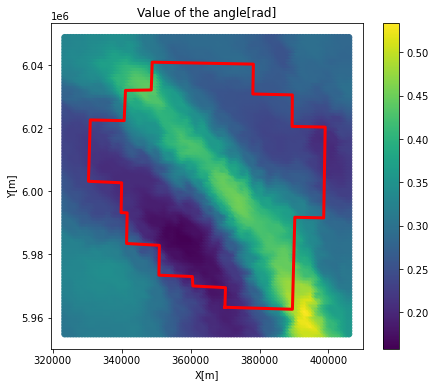

In [8]:
gradi = grad(depth+H)
gradient = project(gradi,ME2) 
gradient_values = gradient.compute_vertex_values(mesh) #to get all the data  from gradient

# Calcul for the gradient in the X direction
gradient_X = []
for i in range(0,int(len(gradient_values)/2)):
    gradient_X.append(gradient_values[i])

# Calcul for the gradient in the Y direction
gradient_Y = []
for i in range(int(len(gradient_values)/2),len(gradient_values)):
    gradient_Y.append(gradient_values[i])

# Creation of a panda fram
panda = pd.DataFrame({'Coord X':mesh.coordinates()[:,0],'Coord Y':mesh.coordinates()[:,1],'Grad X':gradient_X[:],'Grad Y':gradient_Y[:] })

# Calcul of the norme of the gradient
Norme=[]
for i in range(len(panda['Grad Y'])):
    Norme_numpy = math.sqrt(panda['Grad X'][i]**2+panda['Grad Y'][i]**2)
    Norme.append(Norme_numpy)
panda['Norme Gradient']=Norme

# Transposition du gradient; norme(gradient)=angle
angle_Points = np.array(list(zip(panda['Coord X'], panda['Coord Y'])))

x_mesh = np.linspace(xmin, xmax, num=100)  # Vous pouvez ajuster le nombre de points de la grille si nécessaire
y_mesh = np.linspace(ymin, ymax, num=100)
X_mesh, Y_mesh = np.meshgrid(x_mesh, y_mesh)
angle_rad_panda = griddata((panda['Coord X'],panda['Coord Y']),panda['Norme Gradient'], (X_mesh,Y_mesh),method='linear')

# Plot de l'angle
plt.figure(figsize=(7, 6))
plt.scatter(X_mesh,Y_mesh,c=angle_rad_panda)
plt.colorbar()
plt.title('Value of the angle[rad]')
plt.xlabel('X[m]')
plt.ylabel('Y[m]')
angle_value=np.array(panda['Norme Gradient'])
ax = plt.gca()
plot_AOI(ax, AOI, 'red')
angle_points = np.array(list(zip(panda['Coord X'], panda['Coord Y'])))
angle_rad = angle_function(mesh,angle_points,angle_value.flatten(), ME1)

# Define problem

In [9]:
# Step in time
t = 0.0 # Initialize initial time
Nt = 0 # Initialize number of iterations
List_t = [t] # Create list of step times

problem = define_problem(dt, t,
                         Sources_g,
                         ME1,
                         H, phi, sg, g,
                         rho_g, rho_w, rho_g0, rho_w0, mug, muw,
                         cr, cg, cw,
                         u, p, h, p0, h0, du,
                         sigma,
                         v_p, v_h,
                         k, krg, krw, depth, angle_rad)

solver = NewtonSolver()
solver.parameters["linear_solver"] = "gmres" # mumps
solver.parameters["convergence_criterion"] = "incremental" # "residual"
solver.parameters["relative_tolerance"] = 1e-8
solver.parameters["absolute_tolerance"] = 1e-7
solver.parameters["maximum_iterations"] = 20

# Main loop (data saved in the main loop)

In [10]:
# Prepare folder to save results
for f in os.listdir("Diffusion_model/output/p/"): os.remove(os.path.join("Diffusion_model/output/p/", f))
for f in os.listdir("Diffusion_model/output/h/"): os.remove(os.path.join("Diffusion_model/output/h/", f))
file_p = File ("Diffusion_model/output/p/output_p.pvd") ; file_h = File ("Diffusion_model/output/h/output_h.pvd")
file_p << u.split()[0] ; file_h << u.split()[1]

Mass_found0 = assemble(h*rho_g(p)*phi*dx)*sg # Initial CO2 mass found
List_err = [0] # Create list to save relative difference of CO2 mass (between injected and found)
time0 = time.time() # Save current time to calulate loop duration

while (t < T_tot):
    Nt += 1
    
    print(Fore.BLUE+'Iteration ' + str(Nt) + ' : t = '+day_format(t)+' ------> t = '+day_format(t+dt) + ' (dt = ' + day_format(dt) + ')' )
    print(Style.RESET_ALL)
    t += dt ; List_t.append(t)
    
    u0.vector()[:] = u.vector()[:] # Initialize new value
    (no_of_iterations,converged) = solver.solve(problem, u.vector()) # Solve problem
    Mass_found = assemble(h*rho_g(p)*phi*dx)*sg
    Expected_injected_mass = injected_mass(t, Sources_g)
    if no_of_iterations > 10 : dt /= 16
    elif no_of_iterations > 4 : dt /= 2
    elif dt<dt_max/2 : dt *= 2
    
    # Redefine the problem with new values
    problem = define_problem(dt, t,
                             Sources_g,
                             ME1,
                             H, phi, sg, g,
                             rho_g, rho_w, rho_g0, rho_w0, mug, muw,
                             cr, cg, cw,
                             u, p, h, p0, h0, du,
                             sigma,
                             v_p, v_h,
                             k, krg, krw, depth, angle_rad)
    
    file_p << u.split()[0]
    file_h << u.split()[1]
    
    print(Fore.GREEN + 'Expected injected mass at t = ' + day_format(t) + " : " + str(Expected_injected_mass*1e-9) + ' Mt')
    print(Fore.GREEN + 'Injected mass found at t = ' + day_format(t) + " : " + str((Mass_found-Mass_found0)*1e-9) + ' Mt (cumulative)')
    if Expected_injected_mass != 0:
        print(Fore.GREEN + 'Relative difference = ' + str(100*abs((Expected_injected_mass-Mass_found+Mass_found0)/Expected_injected_mass)) + ' %')
        List_err.append(abs((Expected_injected_mass-Mass_found+Mass_found0)/Expected_injected_mass))
    else:
        List_err.append(0)

timef = time.time()

Iteration 1 : t = 0 s ------> t = 1 min (dt = 1 min)

Newton iteration 0: r (abs) = 1.568e+03 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 1.033e-03 (tol = 1.000e-07) r (rel) = 6.590e-07 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 7.454e-08 (tol = 1.000e-07) r (rel) = 4.755e-11 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 15 linear solver iterations.
Expected injected mass at t = 1 min : 0.0 Mt
Injected mass found at t = 1 min : 0.0 Mt (cumulative)
Iteration 2 : t = 1 min ------> t = 3 min (dt = 2 min)

Newton iteration 0: r (abs) = 3.125e+03 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 3.193e-02 (tol = 1.000e-07) r (rel) = 1.022e-05 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 7.981e-08 (tol = 1.000e-07) r (rel) = 2.554e-11 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 14 linear solver iterations.
Expected injected mass at t = 3 min : 0.0 Mt
Injected mass found at t 

Newton iteration 1: r (abs) = 1.506e+03 (tol = 1.000e-07) r (rel) = 9.533e-05 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.168e-01 (tol = 1.000e-07) r (rel) = 7.396e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 71 linear solver iterations.
Expected injected mass at t = 45.5 days : 0.0 Mt
Injected mass found at t = 45.5 days : 0.0 Mt (cumulative)
Iteration 17 : t = 45.5 days ------> t = 91.0 days (dt = 45.5 days)

Newton iteration 0: r (abs) = 2.558e+07 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 2.829e+03 (tol = 1.000e-07) r (rel) = 1.106e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 2.813e-01 (tol = 1.000e-07) r (rel) = 1.100e-08 (tol = 1.000e-08)
Newton iteration 3: r (abs) = 3.949e-06 (tol = 1.000e-07) r (rel) = 1.544e-13 (tol = 1.000e-08)
Newton solver finished in 4 iterations and 113 linear solver iterations.
Expected injected mass at t = 91.0 days : 0.0 Mt
Injected mass found at t = 91.0 days : 0.0 Mt (cumula

Newton iteration 0: r (abs) = 1.289e+07 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 1.726e+03 (tol = 1.000e-07) r (rel) = 1.339e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.798e-02 (tol = 1.000e-07) r (rel) = 1.395e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 86 linear solver iterations.
Expected injected mass at t = 2.11 years : 0.0 Mt
Injected mass found at t = 2.11 years : 0.0 Mt (cumulative)
Iteration 33 : t = 2.11 years ------> t = 2.24 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 1.262e+07 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 1.672e+03 (tol = 1.000e-07) r (rel) = 1.325e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.713e-02 (tol = 1.000e-07) r (rel) = 1.357e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 86 linear solver iterations.
Expected injected mass at t = 2.24 years : 0.0 Mt
Injected mass found at t = 2.24 years : 0.0 Mt (c

Newton iteration 1: r (abs) = 1.007e+03 (tol = 1.000e-07) r (rel) = 1.002e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.080e-02 (tol = 1.000e-07) r (rel) = 1.075e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 86 linear solver iterations.
Expected injected mass at t = 3.99 years : 0.0 Mt
Injected mass found at t = 3.99 years : 0.0 Mt (cumulative)
Iteration 48 : t = 3.99 years ------> t = 4.11 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 9.926e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 1.216e+03 (tol = 1.000e-07) r (rel) = 1.225e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.833e-02 (tol = 1.000e-07) r (rel) = 1.847e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 86 linear solver iterations.
Expected injected mass at t = 4.11 years : 0.0 Mt
Injected mass found at t = 4.11 years : 0.0 Mt (cumulative)
Iteration 49 : t = 4.11 years ------> t = 4.23 years (dt = 45.5 days)

Newton iterati

Newton iteration 1: r (abs) = 6.036e+02 (tol = 1.000e-07) r (rel) = 7.032e-05 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.422e-02 (tol = 1.000e-07) r (rel) = 1.656e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 86 linear solver iterations.
Expected injected mass at t = 5.86 years : 0.0 Mt
Injected mass found at t = 5.86 years : 0.0 Mt (cumulative)
Iteration 63 : t = 5.86 years ------> t = 5.98 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 8.512e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 5.678e+02 (tol = 1.000e-07) r (rel) = 6.670e-05 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.577e-02 (tol = 1.000e-07) r (rel) = 1.853e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 85 linear solver iterations.
Expected injected mass at t = 5.98 years : 0.0 Mt
Injected mass found at t = 5.98 years : 0.0 Mt (cumulative)
Iteration 64 : t = 5.98 years ------> t = 6.1 years (dt = 45.5 days)

Newton iteratio

Newton iteration 1: r (abs) = 4.512e+02 (tol = 1.000e-07) r (rel) = 5.849e-05 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.222e-02 (tol = 1.000e-07) r (rel) = 1.584e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 85 linear solver iterations.
Expected injected mass at t = 7.73 years : 0.0 Mt
Injected mass found at t = 7.73 years : 0.0 Mt (cumulative)
Iteration 78 : t = 7.73 years ------> t = 7.85 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 7.669e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 4.488e+02 (tol = 1.000e-07) r (rel) = 5.853e-05 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.321e-02 (tol = 1.000e-07) r (rel) = 1.722e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 84 linear solver iterations.
Expected injected mass at t = 7.85 years : 0.0 Mt
Injected mass found at t = 7.85 years : 0.0 Mt (cumulative)
Iteration 79 : t = 7.85 years ------> t = 7.98 years (dt = 45.5 days)

Newton iterati

Newton iteration 1: r (abs) = 2.938e+02 (tol = 1.000e-07) r (rel) = 4.114e-05 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.061e-02 (tol = 1.000e-07) r (rel) = 1.486e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 86 linear solver iterations.
Expected injected mass at t = 9.6 years : 0.0 Mt
Injected mass found at t = 9.6 years : 0.0 Mt (cumulative)
Iteration 93 : t = 9.6 years ------> t = 9.72 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 7.109e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 2.863e+02 (tol = 1.000e-07) r (rel) = 4.027e-05 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.095e-02 (tol = 1.000e-07) r (rel) = 1.540e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 86 linear solver iterations.
Expected injected mass at t = 9.72 years : 0.0 Mt
Injected mass found at t = 9.72 years : 0.0 Mt (cumulative)
Iteration 94 : t = 9.72 years ------> t = 9.85 years (dt = 45.5 days)

Newton iteration 

Newton iteration 2: r (abs) = 1.168e-02 (tol = 1.000e-07) r (rel) = 1.738e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 84 linear solver iterations.
Expected injected mass at t = 11.47 years : 0.0 Mt
Injected mass found at t = 11.47 years : 0.0 Mt (cumulative)
Iteration 108 : t = 11.47 years ------> t = 11.59 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 6.695e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 2.803e+02 (tol = 1.000e-07) r (rel) = 4.186e-05 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.121e-02 (tol = 1.000e-07) r (rel) = 1.675e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 85 linear solver iterations.
Expected injected mass at t = 11.59 years : 0.0 Mt
Injected mass found at t = 11.59 years : 0.0 Mt (cumulative)
Iteration 109 : t = 11.59 years ------> t = 11.72 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 6.671e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newt

Newton iteration 2: r (abs) = 1.613e-02 (tol = 1.000e-07) r (rel) = 2.529e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 82 linear solver iterations.
Expected injected mass at t = 13.34 years : 0.0 Mt
Injected mass found at t = 13.34 years : 0.0 Mt (cumulative)
Iteration 123 : t = 13.34 years ------> t = 13.46 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 6.358e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 8.367e+02 (tol = 1.000e-07) r (rel) = 1.316e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.698e-02 (tol = 1.000e-07) r (rel) = 2.670e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 83 linear solver iterations.
Expected injected mass at t = 13.46 years : 0.0 Mt
Injected mass found at t = 13.46 years : 0.0 Mt (cumulative)
Iteration 124 : t = 13.46 years ------> t = 13.59 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 6.338e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newt

Newton iteration 0: r (abs) = 6.064e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 8.396e+02 (tol = 1.000e-07) r (rel) = 1.385e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 4.450e-03 (tol = 1.000e-07) r (rel) = 7.337e-10 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 84 linear solver iterations.
Expected injected mass at t = 15.33 years : 0.0 Mt
Injected mass found at t = 15.33 years : 0.0 Mt (cumulative)
Iteration 139 : t = 15.33 years ------> t = 15.46 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 6.046e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 8.260e+02 (tol = 1.000e-07) r (rel) = 1.366e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 4.186e-03 (tol = 1.000e-07) r (rel) = 6.923e-10 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 84 linear solver iterations.
Expected injected mass at t = 15.46 years : 0.0 Mt
Injected mass found at t = 15.46 years : 0.

Newton iteration 1: r (abs) = 8.111e+02 (tol = 1.000e-07) r (rel) = 1.399e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 6.224e-03 (tol = 1.000e-07) r (rel) = 1.074e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 84 linear solver iterations.
Expected injected mass at t = 17.2 years : 0.0 Mt
Injected mass found at t = 17.2 years : 0.0 Mt (cumulative)
Iteration 154 : t = 17.2 years ------> t = 17.33 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 5.781e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 8.147e+02 (tol = 1.000e-07) r (rel) = 1.409e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 6.490e-03 (tol = 1.000e-07) r (rel) = 1.123e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 84 linear solver iterations.
Expected injected mass at t = 17.33 years : 0.0 Mt
Injected mass found at t = 17.33 years : 0.0 Mt (cumulative)
Iteration 155 : t = 17.33 years ------> t = 17.45 years (dt = 45.5 days)

Newton 

Newton iteration 1: r (abs) = 8.134e+02 (tol = 1.000e-07) r (rel) = 1.466e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.078e-02 (tol = 1.000e-07) r (rel) = 1.943e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 84 linear solver iterations.
Expected injected mass at t = 19.07 years : 0.0 Mt
Injected mass found at t = 19.07 years : 0.0 Mt (cumulative)
Iteration 169 : t = 19.07 years ------> t = 19.2 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 5.533e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 8.110e+02 (tol = 1.000e-07) r (rel) = 1.466e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.110e-02 (tol = 1.000e-07) r (rel) = 2.006e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 84 linear solver iterations.
Expected injected mass at t = 19.2 years : 0.0 Mt
Injected mass found at t = 19.2 years : 0.0 Mt (cumulative)
Iteration 170 : t = 19.2 years ------> t = 19.32 years (dt = 45.5 days)

Newton i

Newton iteration 1: r (abs) = 4.104e+02 (tol = 1.000e-07) r (rel) = 7.721e-05 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 9.703e-03 (tol = 1.000e-07) r (rel) = 1.825e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 84 linear solver iterations.
Expected injected mass at t = 20.94 years : 0.0 Mt
Injected mass found at t = 20.94 years : 0.0 Mt (cumulative)
Iteration 184 : t = 20.94 years ------> t = 21.07 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 5.300e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 4.111e+02 (tol = 1.000e-07) r (rel) = 7.757e-05 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 9.644e-03 (tol = 1.000e-07) r (rel) = 1.820e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 84 linear solver iterations.
Expected injected mass at t = 21.07 years : 0.0 Mt
Injected mass found at t = 21.07 years : 0.0 Mt (cumulative)
Iteration 185 : t = 21.07 years ------> t = 21.19 years (dt = 45.5 days)

Newt

Newton iteration 0: r (abs) = 5.093e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 4.152e+02 (tol = 1.000e-07) r (rel) = 8.154e-05 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 9.031e-03 (tol = 1.000e-07) r (rel) = 1.773e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 83 linear solver iterations.
Expected injected mass at t = 22.81 years : 0.0 Mt
Injected mass found at t = 22.81 years : 0.0 Mt (cumulative)
Iteration 199 : t = 22.81 years ------> t = 22.94 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 5.078e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 4.152e+02 (tol = 1.000e-07) r (rel) = 8.176e-05 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 8.858e-03 (tol = 1.000e-07) r (rel) = 1.744e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 83 linear solver iterations.
Expected injected mass at t = 22.94 years : 0.0 Mt
Injected mass found at t = 22.94 years : 0.

Newton iteration 1: r (abs) = 4.115e+02 (tol = 1.000e-07) r (rel) = 8.432e-05 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 7.841e-03 (tol = 1.000e-07) r (rel) = 1.607e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 81 linear solver iterations.
Expected injected mass at t = 24.68 years : 0.0 Mt
Injected mass found at t = 24.68 years : 0.0 Mt (cumulative)
Iteration 214 : t = 24.68 years ------> t = 24.81 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 4.867e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 4.111e+02 (tol = 1.000e-07) r (rel) = 8.447e-05 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 7.479e-03 (tol = 1.000e-07) r (rel) = 1.537e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 81 linear solver iterations.
Expected injected mass at t = 24.81 years : 0.0 Mt
Injected mass found at t = 24.81 years : 0.0 Mt (cumulative)
Iteration 215 : t = 24.81 years ------> t = 24.93 years (dt = 45.5 days)

Newt

Newton iteration 2: r (abs) = 2.955e-03 (tol = 1.000e-07) r (rel) = 6.317e-10 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 82 linear solver iterations.
Expected injected mass at t = 26.55 years : 0.0 Mt
Injected mass found at t = 26.55 years : 0.0 Mt (cumulative)
Iteration 229 : t = 26.55 years ------> t = 26.68 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 4.665e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 4.020e+02 (tol = 1.000e-07) r (rel) = 8.619e-05 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 2.672e-03 (tol = 1.000e-07) r (rel) = 5.728e-10 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 82 linear solver iterations.
Expected injected mass at t = 26.68 years : 0.0 Mt
Injected mass found at t = 26.68 years : 0.0 Mt (cumulative)
Iteration 230 : t = 26.68 years ------> t = 26.8 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 4.652e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newto

Newton iteration 2: r (abs) = 1.767e-03 (tol = 1.000e-07) r (rel) = 3.941e-10 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 82 linear solver iterations.
Expected injected mass at t = 28.42 years : 0.0 Mt
Injected mass found at t = 28.42 years : 0.0 Mt (cumulative)
Iteration 244 : t = 28.42 years ------> t = 28.55 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 4.472e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 3.895e+02 (tol = 1.000e-07) r (rel) = 8.711e-05 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 2.001e-03 (tol = 1.000e-07) r (rel) = 4.474e-10 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 82 linear solver iterations.
Expected injected mass at t = 28.55 years : 0.0 Mt
Injected mass found at t = 28.55 years : 0.0 Mt (cumulative)
Iteration 245 : t = 28.55 years ------> t = 28.67 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 4.459e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newt

Newton iteration 0: r (abs) = 5.676e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 3.160e+04 (tol = 1.000e-07) r (rel) = 5.566e-03 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.311e+01 (tol = 1.000e-07) r (rel) = 2.309e-06 (tol = 1.000e-08)
Newton iteration 3: r (abs) = 7.730e-04 (tol = 1.000e-07) r (rel) = 1.362e-10 (tol = 1.000e-08)
Newton solver finished in 4 iterations and 106 linear solver iterations.
Expected injected mass at t = 30.23 years : 0.2557787671232877 Mt
Injected mass found at t = 30.23 years : 0.20147454137369666 Mt (cumulative)
Relative difference = 21.230935765444478 %
Iteration 259 : t = 30.23 years ------> t = 30.36 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 7.483e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 6.421e+04 (tol = 1.000e-07) r (rel) = 8.581e-03 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.032e+02 (tol = 1.000e-07) r (rel) = 1.379e-05 (tol = 1.000e

Newton iteration 0: r (abs) = 4.566e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 6.901e+03 (tol = 1.000e-07) r (rel) = 1.512e-03 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 4.649e-01 (tol = 1.000e-07) r (rel) = 1.018e-07 (tol = 1.000e-08)
Newton iteration 3: r (abs) = 2.123e-05 (tol = 1.000e-07) r (rel) = 4.651e-12 (tol = 1.000e-08)
Newton solver finished in 4 iterations and 125 linear solver iterations.
Expected injected mass at t = 31.73 years : 1.8717349315068494 Mt
Injected mass found at t = 31.73 years : 1.829769428897893 Mt (cumulative)
Relative difference = 2.2420644025258323 %
Iteration 271 : t = 31.73 years ------> t = 31.85 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 4.520e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 6.257e+03 (tol = 1.000e-07) r (rel) = 1.384e-03 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 2.927e-01 (tol = 1.000e-07) r (rel) = 6.477e-08 (tol = 1.000e-0

Expected injected mass at t = 33.1 years : 3.3530280821917806 Mt
Injected mass found at t = 33.1 years : 3.3639871701335307 Mt (cumulative)
Relative difference = 0.3268415197580571 %
Iteration 282 : t = 33.1 years ------> t = 33.22 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 4.209e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 3.283e+03 (tol = 1.000e-07) r (rel) = 7.799e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 9.334e-02 (tol = 1.000e-07) r (rel) = 2.218e-08 (tol = 1.000e-08)
Newton iteration 3: r (abs) = 1.480e-06 (tol = 1.000e-07) r (rel) = 3.515e-13 (tol = 1.000e-08)
Newton solver finished in 4 iterations and 136 linear solver iterations.
Expected injected mass at t = 33.22 years : 3.487691095890411 Mt
Injected mass found at t = 33.22 years : 3.5058063497400815 Mt (cumulative)
Relative difference = 0.5194053415744254 %
Iteration 283 : t = 33.22 years ------> t = 33.35 years (dt = 45.5 days)

Newton iteration 0: r (abs) =

Newton iteration 2: r (abs) = 6.224e-02 (tol = 1.000e-07) r (rel) = 1.547e-08 (tol = 1.000e-08)
Newton iteration 3: r (abs) = 6.181e-07 (tol = 1.000e-07) r (rel) = 1.536e-13 (tol = 1.000e-08)
Newton solver finished in 4 iterations and 136 linear solver iterations.
Expected injected mass at t = 34.6 years : 4.968984246575342 Mt
Injected mass found at t = 34.6 years : 5.083296249454073 Mt (cumulative)
Relative difference = 2.3005104706764845 %
Iteration 294 : t = 34.6 years ------> t = 34.72 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 4.010e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 2.425e+03 (tol = 1.000e-07) r (rel) = 6.048e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 6.008e-02 (tol = 1.000e-07) r (rel) = 1.498e-08 (tol = 1.000e-08)
Newton iteration 3: r (abs) = 5.109e-07 (tol = 1.000e-07) r (rel) = 1.274e-13 (tol = 1.000e-08)
Newton solver finished in 4 iterations and 136 linear solver iterations.
Expected injected mass a

Newton iteration 1: r (abs) = 2.035e+03 (tol = 1.000e-07) r (rel) = 5.269e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 4.590e-02 (tol = 1.000e-07) r (rel) = 1.188e-08 (tol = 1.000e-08)
Newton iteration 3: r (abs) = 3.751e-07 (tol = 1.000e-07) r (rel) = 9.711e-14 (tol = 1.000e-08)
Newton solver finished in 4 iterations and 134 linear solver iterations.
Expected injected mass at t = 36.09 years : 6.584940410958905 Mt
Injected mass found at t = 36.09 years : 6.838434779132939 Mt (cumulative)
Relative difference = 3.8496076251830513 %
Iteration 306 : t = 36.09 years ------> t = 36.22 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 3.851e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 2.008e+03 (tol = 1.000e-07) r (rel) = 5.214e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 4.413e-02 (tol = 1.000e-07) r (rel) = 1.146e-08 (tol = 1.000e-08)
Newton iteration 3: r (abs) = 3.863e-07 (tol = 1.000e-07) r (rel) = 1.003e-13 (tol = 1.000e-08

Newton iteration 1: r (abs) = 1.745e+03 (tol = 1.000e-07) r (rel) = 4.691e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 7.416e-02 (tol = 1.000e-07) r (rel) = 1.993e-08 (tol = 1.000e-08)
Newton iteration 3: r (abs) = 4.513e-07 (tol = 1.000e-07) r (rel) = 1.213e-13 (tol = 1.000e-08)
Newton solver finished in 4 iterations and 131 linear solver iterations.
Expected injected mass at t = 37.59 years : 8.200896575342465 Mt
Injected mass found at t = 37.59 years : 8.659162459900111 Mt (cumulative)
Relative difference = 5.587997365257687 %
Iteration 318 : t = 37.59 years ------> t = 37.71 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 3.709e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 1.723e+03 (tol = 1.000e-07) r (rel) = 4.645e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 7.138e-02 (tol = 1.000e-07) r (rel) = 1.924e-08 (tol = 1.000e-08)
Newton iteration 3: r (abs) = 4.194e-07 (tol = 1.000e-07) r (rel) = 1.131e-13 (tol = 1.000e-08)

Newton iteration 2: r (abs) = 5.279e-02 (tol = 1.000e-07) r (rel) = 1.466e-08 (tol = 1.000e-08)
Newton iteration 3: r (abs) = 1.986e-07 (tol = 1.000e-07) r (rel) = 5.516e-14 (tol = 1.000e-08)
Newton solver finished in 4 iterations and 117 linear solver iterations.
Expected injected mass at t = 38.96 years : 9.682189726027397 Mt
Injected mass found at t = 38.96 years : 10.350800986634281 Mt (cumulative)
Relative difference = 6.905579001509768 %
Iteration 329 : t = 38.96 years ------> t = 39.08 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 3.589e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 1.539e+03 (tol = 1.000e-07) r (rel) = 4.288e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 4.782e-02 (tol = 1.000e-07) r (rel) = 1.332e-08 (tol = 1.000e-08)
Newton iteration 3: r (abs) = 2.242e-07 (tol = 1.000e-07) r (rel) = 6.246e-14 (tol = 1.000e-08)
Newton solver finished in 4 iterations and 117 linear solver iterations.
Expected injected mas

Expected injected mass at t = 40.33 years : 11.16348287671233 Mt
Injected mass found at t = 40.33 years : 12.045151453593823 Mt (cumulative)
Relative difference = 7.897791277314593 %
Iteration 340 : t = 40.33 years ------> t = 40.46 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 3.475e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 1.399e+03 (tol = 1.000e-07) r (rel) = 4.026e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 3.250e-02 (tol = 1.000e-07) r (rel) = 9.352e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 89 linear solver iterations.
Expected injected mass at t = 40.46 years : 11.298145890410959 Mt
Injected mass found at t = 40.46 years : 12.199302348946187 Mt (cumulative)
Relative difference = 7.976144645999506 %
Iteration 341 : t = 40.46 years ------> t = 40.58 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 3.465e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) =

Newton iteration 0: r (abs) = 3.357e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 1.256e+03 (tol = 1.000e-07) r (rel) = 3.742e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 5.031e-02 (tol = 1.000e-07) r (rel) = 1.499e-08 (tol = 1.000e-08)
Newton iteration 3: r (abs) = 1.602e-07 (tol = 1.000e-07) r (rel) = 4.772e-14 (tol = 1.000e-08)
Newton solver finished in 4 iterations and 118 linear solver iterations.
Expected injected mass at t = 41.95 years : 12.914102054794522 Mt
Injected mass found at t = 41.95 years : 14.051065628823297 Mt (cumulative)
Relative difference = 8.804046686363783 %
Iteration 353 : t = 41.95 years ------> t = 42.08 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 3.347e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 1.245e+03 (tol = 1.000e-07) r (rel) = 3.719e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 4.914e-02 (tol = 1.000e-07) r (rel) = 1.468e-08 (tol = 1.000e-0

Newton iteration 0: r (abs) = 3.244e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 1.149e+03 (tol = 1.000e-07) r (rel) = 3.542e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.019e-01 (tol = 1.000e-07) r (rel) = 3.141e-08 (tol = 1.000e-08)
Newton iteration 3: r (abs) = 2.749e-07 (tol = 1.000e-07) r (rel) = 8.475e-14 (tol = 1.000e-08)
Newton solver finished in 4 iterations and 118 linear solver iterations.
Expected injected mass at t = 43.45 years : 14.530058219178082 Mt
Injected mass found at t = 43.45 years : 15.90258224965421 Mt (cumulative)
Relative difference = 9.446101383575646 %
Iteration 365 : t = 43.45 years ------> t = 43.57 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 3.235e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 1.143e+03 (tol = 1.000e-07) r (rel) = 3.533e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.051e-01 (tol = 1.000e-07) r (rel) = 3.248e-08 (tol = 1.000e-08

Newton iteration 2: r (abs) = 1.121e-01 (tol = 1.000e-07) r (rel) = 3.565e-08 (tol = 1.000e-08)
Newton iteration 3: r (abs) = 1.502e-07 (tol = 1.000e-07) r (rel) = 4.776e-14 (tol = 1.000e-08)
Newton solver finished in 4 iterations and 120 linear solver iterations.
Expected injected mass at t = 44.82 years : 16.011351369863014 Mt
Injected mass found at t = 44.82 years : 17.605644642969168 Mt (cumulative)
Relative difference = 9.957268666946954 %
Iteration 376 : t = 44.82 years ------> t = 44.95 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 3.135e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 1.062e+03 (tol = 1.000e-07) r (rel) = 3.388e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.096e-01 (tol = 1.000e-07) r (rel) = 3.497e-08 (tol = 1.000e-08)
Newton iteration 3: r (abs) = 1.415e-07 (tol = 1.000e-07) r (rel) = 4.512e-14 (tol = 1.000e-08)
Newton solver finished in 4 iterations and 121 linear solver iterations.
Expected injected ma

Newton iteration 0: r (abs) = 3.040e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 1.006e+03 (tol = 1.000e-07) r (rel) = 3.310e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 9.808e-02 (tol = 1.000e-07) r (rel) = 3.227e-08 (tol = 1.000e-08)
Newton iteration 3: r (abs) = 1.668e-07 (tol = 1.000e-07) r (rel) = 5.486e-14 (tol = 1.000e-08)
Newton solver finished in 4 iterations and 121 linear solver iterations.
Expected injected mass at t = 46.32 years : 17.627307534246576 Mt
Injected mass found at t = 46.32 years : 19.459410220455574 Mt (cumulative)
Relative difference = 10.393548093771924 %
Iteration 388 : t = 46.32 years ------> t = 46.44 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 3.031e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 9.861e+02 (tol = 1.000e-07) r (rel) = 3.253e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 9.628e-02 (tol = 1.000e-07) r (rel) = 3.177e-08 (tol = 1.000e-

Newton iteration 2: r (abs) = 7.957e-02 (tol = 1.000e-07) r (rel) = 2.700e-08 (tol = 1.000e-08)
Newton iteration 3: r (abs) = 2.427e-07 (tol = 1.000e-07) r (rel) = 8.237e-14 (tol = 1.000e-08)
Newton solver finished in 4 iterations and 118 linear solver iterations.
Expected injected mass at t = 47.69 years : 19.10860068493151 Mt
Injected mass found at t = 47.69 years : 21.167022904211827 Mt (cumulative)
Relative difference = 10.772228972807683 %
Iteration 399 : t = 47.69 years ------> t = 47.81 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 2.939e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 9.282e+02 (tol = 1.000e-07) r (rel) = 3.158e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 7.832e-02 (tol = 1.000e-07) r (rel) = 2.665e-08 (tol = 1.000e-08)
Newton iteration 3: r (abs) = 2.643e-07 (tol = 1.000e-07) r (rel) = 8.992e-14 (tol = 1.000e-08)
Newton solver finished in 4 iterations and 118 linear solver iterations.
Expected injected ma

Newton iteration 0: r (abs) = 2.850e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 7.572e+02 (tol = 1.000e-07) r (rel) = 2.657e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 5.489e-02 (tol = 1.000e-07) r (rel) = 1.926e-08 (tol = 1.000e-08)
Newton iteration 3: r (abs) = 1.898e-07 (tol = 1.000e-07) r (rel) = 6.659e-14 (tol = 1.000e-08)
Newton solver finished in 4 iterations and 118 linear solver iterations.
Expected injected mass at t = 49.18 years : 20.72455684931507 Mt
Injected mass found at t = 49.18 years : 23.036793558755438 Mt (cumulative)
Relative difference = 11.1569898755967 %
Iteration 411 : t = 49.18 years ------> t = 49.31 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 2.842e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 7.528e+02 (tol = 1.000e-07) r (rel) = 2.649e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 5.366e-02 (tol = 1.000e-07) r (rel) = 1.888e-08 (tol = 1.000e-08)

Newton iteration 0: r (abs) = 2.756e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 7.023e+02 (tol = 1.000e-07) r (rel) = 2.548e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 3.972e-02 (tol = 1.000e-07) r (rel) = 1.441e-08 (tol = 1.000e-08)
Newton iteration 3: r (abs) = 4.223e-07 (tol = 1.000e-07) r (rel) = 1.532e-13 (tol = 1.000e-08)
Newton solver finished in 4 iterations and 112 linear solver iterations.
Expected injected mass at t = 50.68 years : 22.340513013698633 Mt
Injected mass found at t = 50.68 years : 24.908296677014558 Mt (cumulative)
Relative difference = 11.49384377046949 %
Iteration 423 : t = 50.68 years ------> t = 50.81 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 2.749e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 6.983e+02 (tol = 1.000e-07) r (rel) = 2.540e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 3.885e-02 (tol = 1.000e-07) r (rel) = 1.414e-08 (tol = 1.000e-0

Newton iteration 0: r (abs) = 2.666e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 6.485e+02 (tol = 1.000e-07) r (rel) = 2.432e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 2.788e-02 (tol = 1.000e-07) r (rel) = 1.046e-08 (tol = 1.000e-08)
Newton iteration 3: r (abs) = 4.435e-07 (tol = 1.000e-07) r (rel) = 1.664e-13 (tol = 1.000e-08)
Newton solver finished in 4 iterations and 114 linear solver iterations.
Expected injected mass at t = 52.18 years : 23.956469178082195 Mt
Injected mass found at t = 52.18 years : 26.777285554952822 Mt (cumulative)
Relative difference = 11.774758441663003 %
Iteration 435 : t = 52.18 years ------> t = 52.3 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 2.659e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 6.442e+02 (tol = 1.000e-07) r (rel) = 2.423e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 2.683e-02 (tol = 1.000e-07) r (rel) = 1.009e-08 (tol = 1.000e-0

Newton iteration 1: r (abs) = 5.998e+02 (tol = 1.000e-07) r (rel) = 2.332e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 2.253e-02 (tol = 1.000e-07) r (rel) = 8.762e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 89 linear solver iterations.
Expected injected mass at t = 53.8 years : 25.707088356164384 Mt
Injected mass found at t = 53.8 years : 28.80764973970404 Mt (cumulative)
Relative difference = 12.061114586693988 %
Iteration 448 : t = 53.8 years ------> t = 53.92 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 2.565e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 5.963e+02 (tol = 1.000e-07) r (rel) = 2.325e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 2.202e-02 (tol = 1.000e-07) r (rel) = 8.588e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 88 linear solver iterations.
Expected injected mass at t = 53.92 years : 25.841751369863015 Mt
Injected mass found at t = 53.92 years : 28.96378010499

Newton iteration 1: r (abs) = 5.560e+02 (tol = 1.000e-07) r (rel) = 2.241e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.661e-02 (tol = 1.000e-07) r (rel) = 6.695e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 89 linear solver iterations.
Expected injected mass at t = 55.42 years : 27.457707534246577 Mt
Injected mass found at t = 55.42 years : 30.83623001384432 Mt (cumulative)
Relative difference = 12.304459414114918 %
Iteration 461 : t = 55.42 years ------> t = 55.54 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 2.474e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 5.528e+02 (tol = 1.000e-07) r (rel) = 2.234e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.635e-02 (tol = 1.000e-07) r (rel) = 6.607e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 89 linear solver iterations.
Expected injected mass at t = 55.54 years : 27.592370547945208 Mt
Injected mass found at t = 55.54 years : 30.99225111

Newton iteration 2: r (abs) = 1.422e-02 (tol = 1.000e-07) r (rel) = 5.939e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 90 linear solver iterations.
Expected injected mass at t = 57.04 years : 29.208326712328766 Mt
Injected mass found at t = 57.04 years : 32.863202877456246 Mt (cumulative)
Relative difference = 12.513130933942767 %
Iteration 474 : t = 57.04 years ------> t = 57.16 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 2.387e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 5.111e+02 (tol = 1.000e-07) r (rel) = 2.141e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.409e-02 (tol = 1.000e-07) r (rel) = 5.905e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 90 linear solver iterations.
Expected injected mass at t = 57.16 years : 29.342989726027398 Mt
Injected mass found at t = 57.16 years : 33.01889323241195 Mt (cumulative)
Relative difference = 12.527365277724241 %
Iteration 475 : t = 57.16 yea

Newton iteration 1: r (abs) = 4.744e+02 (tol = 1.000e-07) r (rel) = 2.054e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.307e-02 (tol = 1.000e-07) r (rel) = 5.659e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 90 linear solver iterations.
Expected injected mass at t = 58.66 years : 30.95894589041096 Mt
Injected mass found at t = 58.66 years : 34.88428919069445 Mt (cumulative)
Relative difference = 12.679189124133924 %
Iteration 487 : t = 58.66 years ------> t = 58.79 years (dt = 45.5 days)

Newton iteration 0: r (abs) = 2.303e+06 (tol = 1.000e-07) r (rel) = 1.000e+00 (tol = 1.000e-08)
Newton iteration 1: r (abs) = 4.714e+02 (tol = 1.000e-07) r (rel) = 2.047e-04 (tol = 1.000e-08)
Newton iteration 2: r (abs) = 1.300e-02 (tol = 1.000e-07) r (rel) = 5.644e-09 (tol = 1.000e-08)
Newton solver finished in 3 iterations and 90 linear solver iterations.
Expected injected mass at t = 58.79 years : 31.09360890410959 Mt
Injected mass found at t = 58.79 years : 35.0395875244

# Loop data

Number of iteration = 497
loop time = 2 min

Searching for extrem values of p and h...


100%|█████████████████████████████████████████████████████████████████████████████████| 497/497 [00:09<00:00, 53.93it/s]


Minimum and maximum pressure in the reservoir during operation : -1170.8769409847273 / 1531.8825846885484 bar
Minimum and maximum value of h during operation : -1.4472200060081788 / 41.00163169150255 m


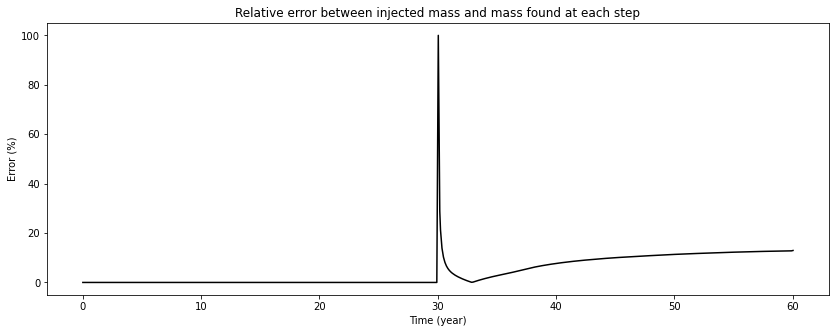

In [11]:

print(Fore.BLUE + 'Number of iteration = ' + str(Nt))
print(Fore.GREEN + 'loop time = ' + day_format(timef - time0))
print(Style.RESET_ALL)

Mass_found = assemble(h*rho_g(p)*phi*dx)*sg # we consider the density as constant
Expected_injected_mass = injected_mass(t, Sources_g)

p_min, p_max, h_min, h_max = min_max_pressure_h_total(Nt, H, g, sg, 50, rho_g, rho_w, List_t)

###########################################################################################################################
# Plot loop data
print('Minimum and maximum pressure in the reservoir during operation : ' + str(p_min) + ' / ' + str(p_max) + ' bar')
print('Minimum and maximum value of h during operation : ' + str(h_min) + ' / ' + str(h_max) + ' m')

#Plot relative error (for mass) curve
plt.figure(figsize=(14, 5))
plt.xlabel('Time (year)') ; plt.ylabel('Error (%)')
plt.plot(np.array(List_t)/(24*3600*365), 100*np.array(List_err), color='black')
plt.title('Relative error between injected mass and mass found at each step')
plt.savefig('Diffusion_model/Figures/QUEST_Model_accuracy.png', dpi=300, bbox_inches='tight')

# Save and plot results
### Top views

In [12]:
def plot_h(iteration, Nx, Ny, AOI, h_min, h_max, List_t, ME1, xmin, xmax, ymin, ymax):
    points = extract_points_p_h(iteration)[0] ; h = extract_points_p_h(iteration)[2]
    points = [[points[i][0], points[i][1]] for i in range(len(points))]
    
    interp = RBFInterpolator(points, h)
    Data = interp(ME1.tabulate_dof_coordinates())
    
    h_function = Function(ME1)
    h_moy = np.nanmean(Data) # Average on the 2D domain
    for l in range(ME1.dim()):
        if np.isnan(Data[l]): # if there is a NaN value, we give the precedent value to the vector.
            h_function.vector()[l] = h_moy
            print('Warning : NaN found after interpolation, replacing by mean value')
        else: h_function.vector()[l] = Data[l]

    print('Maximum pressure at the interface at t = ' + day_format(List_t[iteration]) + ' : ' + str(np.amax(h)) + ' bar')
    print('After interpolation : ' + str(np.amax(Data)) + ' bar')
    fig = plt.figure(figsize=(6, 6))
    plt.colorbar(plot(h_function, mode='color', cmap='YlGnBu', vmin=h_min, vmax=h_max), orientation='vertical')
    plt.title('Thickness of gas (m) at t = ' + day_format(List_t[iteration]))
    ax = plt.gca() ; plot_AOI(ax, np.array(AOI), 'red')
    ax.set_xlabel('Distance (m)') ; ax.set_ylabel('Distance (m)')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    plt.savefig('Diffusion_model/Figures/QUEST_h.png', dpi=300, bbox_inches='tight')

Maximum pressure at the interface at t = 60.03 years : 1532.9230443265596 bar
After interpolation : 1532.9230443583833 bar
Maximum pressure at the interface at t = 60.03 years : 41.012064152024514 bar
After interpolation : 41.01206417105733 bar


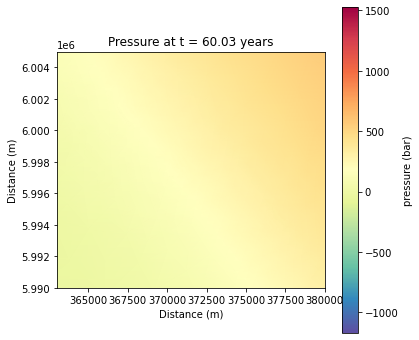

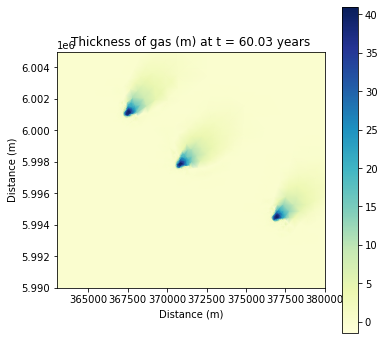

In [13]:
Nx = 1e3 ; Ny = 1e3 ; Nz = 1e3

plot_p(Nt, Nx, Ny, AOI, p_min, p_max, List_t, ME1, 363e3, 380e3, 5990e3, 6005e3)
plot_h(Nt, Nx, Ny, AOI, h_min, h_max, List_t, ME1, 363e3, 380e3, 5990e3, 6005e3)

folder = ''
# plot_pressure_point(folder, [Point(370705.48,5997747.39), Point(367400,6001000), Point(376800,5994400)], mesh, Nt, List_t)

In [14]:
# export_p(100, Nx, Ny, Nz, List_t, AOI, Outline, phi0, k0)
# export_p(300, Nx, Ny, Nz, List_t, AOI, Outline, phi0, k0)
# export_p(450, Nx, Ny, Nz, List_t, AOI, Outline, phi0, k0)

# export_h(100, Nx, Ny, Nz, List_t, AOI, Outline, phi0, k0)
# export_h(300, Nx, Ny, Nz, List_t, AOI, Outline, phi0, k0)
# export_h(450, Nx, Ny, Nz, List_t, AOI, Outline, phi0, k0)

# Export data for mechanical model

In [15]:
# xmax = Outline[1][0]
# xmin = Outline[0][0]
ymax = Outline[2][1]
ymin = Outline[0][1]

XMesh = [] ; YMesh = []
for i in range(54):
    XMesh_tamp = [xmin+(xmax-xmin)*j/49 for j in range(50)]
    XMesh.append(XMesh_tamp)

for i in range(54):
    YMesh_tamp = [ymin+(ymax-ymin)*i/53 for j in range(50)]
    YMesh.append(YMesh_tamp)

X_, Y_ = np.meshgrid(np.array(XMesh)[0], np.array(YMesh)[:,0])
Thick = griddata(H_points, H_field, (X_, Y_), method='linear')
Depth = griddata(depth_points, depth_field, (X_, Y_), method='linear')

# Export mesh for mechanical model (in folder output/)
folder = 'Mechanical_model/Data_from_diffusion_model/RES_data/'

# Export RES
dRES = {'Depth':Depth, 'Thickness': Thick}
with open(folder + 'RES.p', 'wb') as handle: pkl.dump(dRES, handle, protocol=pkl.HIGHEST_PROTOCOL)
    
# Export X and Y coordinates
pkl.dump(np.array(XMesh), open(folder + 'X.p', 'wb')) ; pkl.dump(np.array(YMesh), open(folder + 'Y.p', 'wb'))

# Export Outline
Xcoordinates1 = np.linspace(xmin, xmin, 1000)
Xcoordinates2 = np.linspace(xmin, xmax, 1000)
Xcoordinates3 = np.linspace(xmax, xmax, 1000)
Xcoordinates4 = np.linspace(xmax, xmin, 1000)

Ycoordinates1 = np.linspace(ymin, ymax, 1000)
Ycoordinates2 = np.linspace(ymax, ymax, 1000)
Ycoordinates3 = np.linspace(ymax, ymin, 1000)
Ycoordinates4 = np.linspace(ymin, ymin, 1000)

dOutline = {'X': np.concatenate((Xcoordinates1,Xcoordinates2,Xcoordinates3,Xcoordinates4)), 'Y':np.concatenate((Ycoordinates1,Ycoordinates2,Ycoordinates3,Ycoordinates4))}
dfOutline = pd.DataFrame(data=dOutline)

with open(folder + 'Outline.p', 'wb') as handle: pkl.dump(dfOutline, handle, protocol=pkl.HIGHEST_PROTOCOL)

folder = 'Mechanical_model/Data_from_diffusion_model/Other_data/'
# Export MESH
np.save(folder +'MESH.npy', np.array(mesh.coordinates()))

#Export thickness and depth

pkl.dump(np.array(H_points), open(folder + 'H_points.npy', 'wb'))
pkl.dump(np.array(H_field), open(folder + 'H_field.npy', 'wb'))
pkl.dump(np.array(depth_points), open(folder + 'Depth_points.npy', 'wb'))
pkl.dump(np.array(depth_field), open(folder + 'Depth_field.npy', 'wb'))
    
# Export data for mechanical model in folder 'output/'
# extract_pressure_list(folder_input, folder_output, Nt)